# Self-Driving Car Engineer Nanodegree

### Advanced Lane Finding Project

#### The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Helper Functions

In [2]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh= (0,255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Define a function that thresholds the h-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def h_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(h)
    binary_output[(h > thresh[0]) & (h <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Define a function that takes in chessboard size, paths to open/save images 
# and returns objpoints/imgpoints to undistort an image.
def camera_calibrate(chessboard_size, open_path, save_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    i = chessboard_size[0]
    j = chessboard_size[1]
    objp = np.zeros((i*j,3), np.float32)
    objp[:,:2] = np.mgrid[0:i, 0:j].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(open_path) # camera_cal/calibration*.jpg
    count = 0 # placeholder for counting problematic chessboard images, whose corners are not found
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and store images whose corners are found
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = save_path+'corners_found'+str(idx + 1)+'.jpg'
            cv2.imwrite(write_name, img)
        else:
            count += 1
   # print("There are " + str(count) + " image/s whose corners couldn't be found.")
    return objpoints, imgpoints

# Define a function that undistorts an image
def undistort_img(img, objpoints, imgpoints):
    h, w = img.shape[:2]
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Performs perspective transform of given image
def perspective_trans(img):
    sizex = img.shape[0] # 720
    sizey = img.shape[1] # 1280
    src = np.float32([[588,470], [245,719], [1142, 719],[734,470]])
    dst = np.float32([[320,0], [320,720], [960, 720],[960,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (sizey, sizex), flags=cv2.INTER_LINEAR)
    #gray = (0.2989*warped[:,:,0] + 0.5870*warped[:,:,1] + 0.1140*warped[:,:,2])/3.0
    return {'warped':warped, 'dst':dst, 'src':src, 'Minv': Minv}

# Evaluates curvature and offset for given frame using sliding window method
def curvature_eval(binary_warped, nwindows = 20, margin = 50, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # nwindows = the number of sliding windows
    # margin = width of the windows +/- margin
    # minpix = minimum number of pixels found to recenter window
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate radii of curvature
    y_eval = binary_warped.shape[0] - 1 # position at which curvature is calculated
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate offset of car assuming dashcam is mounted at car centerline
    offset_val = xm_per_pix * 0.5 * (binary_warped.shape[1] - (leftx_base + rightx_base))
    
    if offset_val < 0:
        offset_dir = 'left'
    else:
        offset_dir = 'right'
    offset = {'offset_val':offset_val, 'offset_dir':offset_dir}
    
    return {'left_fit':left_fit,'right_fit':right_fit, 'nonzerox':nonzerox,'nonzeroy':nonzeroy,\
            'left_lane_inds':left_lane_inds,'right_lane_inds':right_lane_inds,\
            'left_curverad':left_curverad, 'right_curverad':right_curverad,\
            'right_fit_cr':right_fit_cr,'offset':offset, 'out_img':out_img }

# Projects the identified lane lines back down to the road
def map_color(Minv, warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

### Camera Calibration

In [3]:
open_path = 'camera_cal/calibration*.jpg'
save_path = 'camera_cal/'
chessboard_size = [9, 6]
objpoints = []
imgpoints = []
objpoints, imgpoints = camera_calibrate(chessboard_size, open_path, save_path)

### Pipeline (single image)

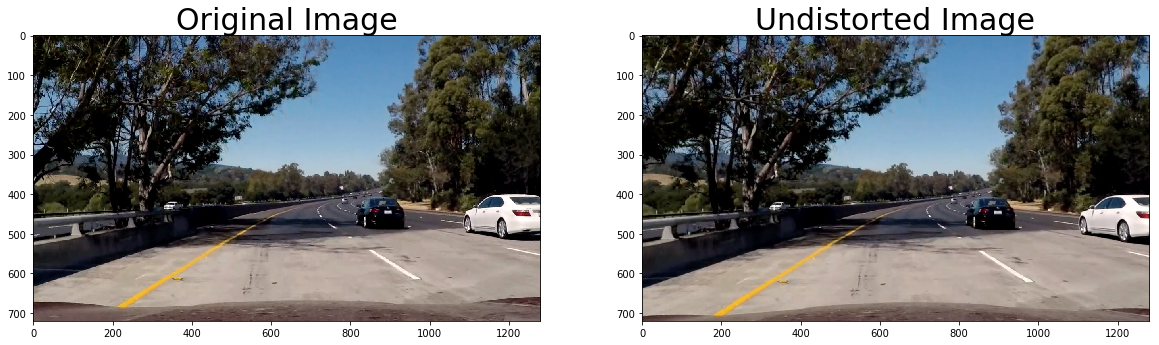

In [4]:
# Step 1. Undistort image
# load test image to undistort
load_path = 'test_images/test' + str(random.randint(1,6)) + '.jpg'
img = mpimg.imread(load_path)
und_img = undistort_img(img, objpoints, imgpoints)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(und_img)
ax2.set_title('Undistorted Image', fontsize=30)

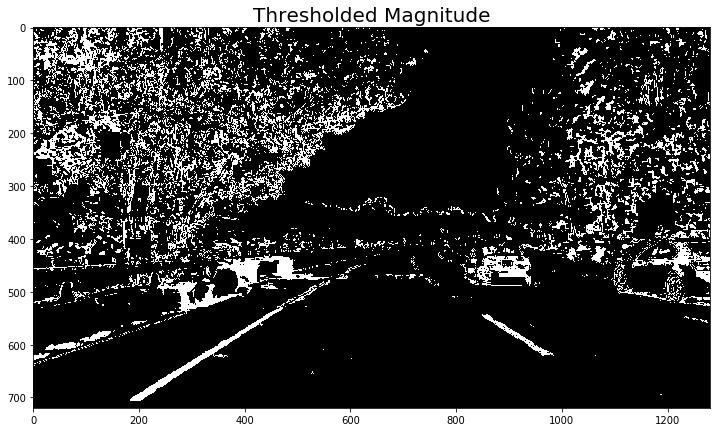

In [5]:
# Step 2. Create a thresholded binary image
ksize = 5 # Sobel kernel size, choose a larger odd number to smooth gradient measurements
img = und_img
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 100))
s_binary = s_select(img, thresh=(150, 255))
combined = np.zeros_like(gradx)
combined[(((gradx == 1) & (mag_binary == 1))| (s_binary == 1))] = 1

# Plot the result
f, ax = plt.subplots(1,1, figsize=(16, 7))
ax.imshow(combined, cmap='gray')
ax.set_title('Thresholded Magnitude', fontsize=20)



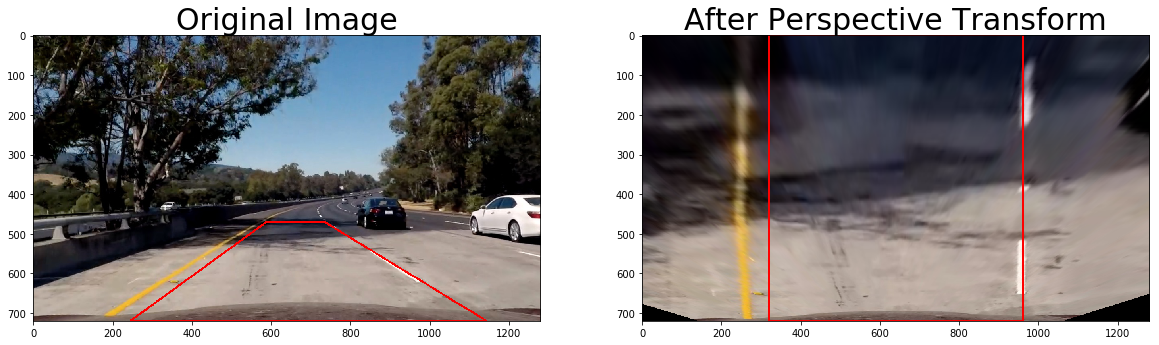

In [6]:
# Step 3. Perform a perspective transform
persp_obj = perspective_trans(img)
warped = persp_obj['warped']
dst = persp_obj['dst']
src = persp_obj['src']
Minv = persp_obj['Minv'] # save for use in step 6

pts1 = np.array(src, np.int32)
pts1 = pts1.reshape((-1,1,2))
cv2.polylines(img,[pts1],True,(255,0,0),3)

pts2 = np.array(dst, np.int32)
pts2 = pts2.reshape((-1,1,2))
cv2.polylines(warped,[pts2],True,(255,0,0),3)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('After Perspective Transform', fontsize=30)
    

The radius of curvature is: 1004.21283084
The car is offset 0.190285714286 towards right.


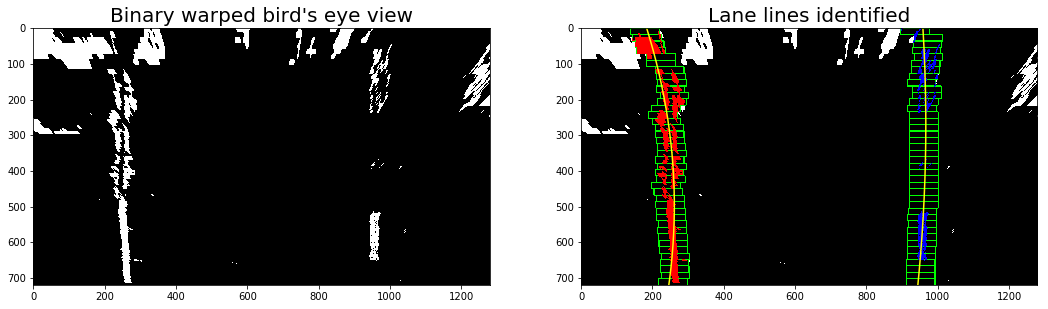

In [7]:
# Step 4. Find lane line pixels in a binary warped image and fit 2nd order polynomial
# Step 5. Find radius of curvature and offset of vehicle from lane centerline
pers_obj2 = perspective_trans(combined)
binary_warped = pers_obj2['warped']
curv_obj = curvature_eval(binary_warped, nwindows = 40, margin = 40, minpix = 40)
left_fit = curv_obj['left_fit']
right_fit = curv_obj['right_fit']
nonzerox = curv_obj['nonzerox']
nonzeroy = curv_obj['nonzeroy']
left_lane_inds = curv_obj['left_lane_inds']
right_lane_inds = curv_obj['right_lane_inds']
offset = curv_obj['offset']
out_img = curv_obj['out_img']
curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
print('The radius of curvature is: ' + str(curvature))
print('The car is offset ' + str(offset['offset_val']) + ' towards ' + offset['offset_dir'] + '.')

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,9))
ax1.imshow(binary_warped, cmap = 'gray')
ax1.set_title('Binary warped bird\'s eye view', fontsize = 20)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Lane lines identified', fontsize = 20)

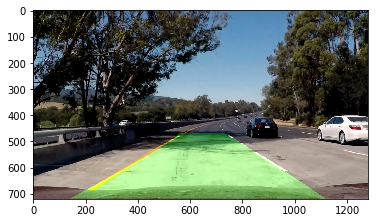

In [8]:
# Step 6. Overlay identified lane on original image
img = mpimg.imread(load_path) # reload original image
plt.imshow(map_color(Minv, binary_warped, img, left_fitx, right_fitx, ploty))

### Pipeline (video)

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [10]:
def process_img(img, obj_points = objpoints, img_points = imgpoints, ksize=5, nwindows = 40, margin = 40, minpix = 40):
    # Step 1. Undistort image
    und_img = undistort_img(img, objpoints, imgpoints) 
    # Step 2. Apply each of the thresholding functions
    gradx = abs_sobel_thresh(und_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(und_img, sobel_kernel=ksize, mag_thresh=(50, 100))
    s_binary = s_select(und_img, thresh=(150, 255))
    combined = np.zeros_like(gradx)
    combined[(((gradx == 1) & (mag_binary == 1))| (s_binary == 1))] = 1
    # Step 3. Perform a perspective transform
    persp_obj = perspective_trans(combined)
    warped = persp_obj['warped']
    Minv = persp_obj['Minv']
    # Step 4. Find lane line pixels in a binary warped image and fit 2nd order polynomial
    # Step 5. Find radius of curvature and offset of vehicle from lane centerline
    curv_obj = curvature_eval(warped, 40, 40, 40)
    left_fit = curv_obj['left_fit']
    right_fit = curv_obj['right_fit']
    left_lane_inds = curv_obj['left_lane_inds']
    right_lane_inds = curv_obj['right_lane_inds']
    offset = curv_obj['offset']
    curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
    # Step 6. Overlay identified lane on original image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_img = map_color(Minv, warped, img, left_fitx, right_fitx, ploty)
    return lane_img
#{'left_fit':left_fit, 'right_fit':right_fit, 'lane_img':lane_img, \
#             'offset':offset, 'curvature':curvature, 'left_lane_inds':left_lane_inds,\
#            'right_lane_inds':right_lane_inds}

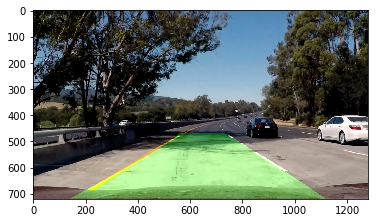

In [16]:
process_img_obj = process_img(img, objpoints, imgpoints, 5, 40, 40, 40)
plt.imshow(process_img_obj)

In [17]:
# load project video
project_video = 'project_video.mp4'
clip1 = VideoFileClip(project_video).subclip(0,5)
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!


In [18]:
%time white_clip.write_videofile('processed_video.mp4', audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video))

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4


 99%|████████████████████████████████████████████████████▌| 125/126 [01:31<00:00,  1.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

Wall time: 1min 32s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('processed_video.mp4'))

In [20]:
clip2 = VideoFileClip(project_video)
white_clip2 = clip2.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip2.write_videofile('processed_video2.mp4', audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('processed_video2.mp4'))

[MoviePy] >>>> Building video processed_video2.mp4
[MoviePy] Writing video processed_video2.mp4


100%|██████████████████████████████████████████████████▉| 1260/1261 [14:58<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video2.mp4 

Wall time: 14min 59s
